In [1]:
from load_data import get_mfcc, get_spectrogram
import matplotlib.pyplot as plt

import os
import pandas as pd
import json
import numpy as np
import librosa

Analyze signal shapes

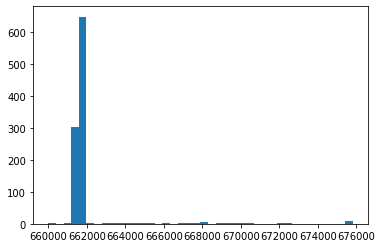

In [2]:
DATASET_PATH = 'data'

signal_shape = []
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        file_path = os.path.join(root, file)
        signal, sample_rate = librosa.load(file_path)
        signal_shape.append(signal.shape[0])

plt.hist(signal_shape, bins=40)
plt.show()

In [3]:
MINIMAL_SHAPE = min(set(signal_shape))
MAXIMAL_SHAPE = max(set(signal_shape))

Prepare dataset

In [4]:
# Calculate number of songs
NUM_OF_GENRES = 10
NUM_OF_SONGS_PER_GENRE = 100
INVALID_SONGS = 1
NUM_OF_SONGS = NUM_OF_GENRES * NUM_OF_SONGS_PER_GENRE - INVALID_SONGS

# Calculate shape of input
EXAMPLE_SONG_PATH = 'data/blues/blues.00000.wav'
input_data_shape = get_mfcc(EXAMPLE_SONG_PATH, 2048, 512, 14, MINIMAL_SHAPE).shape

# Alocate memory to array
x = np.ndarray(shape=(NUM_OF_SONGS, input_data_shape[0], input_data_shape[1]), dtype=np.float32)
y = []


In [5]:
# Create dataset arrays

DATASET_PATH = 'data'

i = 0
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        file_path = os.path.join(root, file)
        spectrogram = get_mfcc(file_path, 2048, 512, 14, MINIMAL_SHAPE)
        label = file.split(".")[0]
        x[i] = spectrogram
        y.append(label)
        i += 1        

In [7]:
input_data_shape

(14, 1290)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

y_train = tf.keras.utils.


In [ ]:
import keras
from keras import layers

model = keras.Sequential()
model.add(layers.Flatten(input_shape=input_data_shape))
model.add(layers.Dense(32, activation="relu"))